In [1]:
from sklearn.datasets import load_boston
from keras.models import Sequential
from keras import Model# input
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Conv1D, Flatten, Concatenate, Input
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import tensorflow as tf

In [2]:
'''
GLOBAL: data
Get the data, store it globally
'''
data = None
globalDasetName = 'dataSetD'  # CHANGE ME HERE!!
np.random.seed(42)


# default param is global param
def load_data(dataset=globalDasetName): 
    global data
    data = pd.read_csv(f'data/{dataset}', delimiter='  ', header = None) # NO HEADER
    data = data.rename(columns={33: 'target', 0: 'mag'})
    # data # 0 is magnitude, and 32 of them are binary.

# pandas data fetch. No splitting.
def get_pandas_data():
  """
  y_target_gene = string of name
  return: X (PANDAS), y_arr (np array)
  """
  load_data()

  y_train = data["target"].to_numpy()
  magParam = data.loc[:, data.columns == "mag"]
  magParam = magParam.to_numpy()
  del data["mag"]
  X_train = data.loc[:, data.columns != "target"]

  
  X_train = X_train.to_numpy()

  return X_train, y_train, magParam


x, y, magParam = get_pandas_data()

# get indexes of split
fullDatasetIdxs = np.arange(len(y))
trainidx, testidx = train_test_split(fullDatasetIdxs, test_size=0.15)

xtrain = x[trainidx]
xtest = x[testidx]
xtrain = xtrain.reshape(xtrain.shape[0], xtrain.shape[1], 1)

ytrain = y[trainidx]
ytest = y[testidx]

magtrain = magParam[trainidx]
magtest = magParam[testidx]

/lus/theta-fs0/software/thetagpu/conda/2021-11-30/mconda3/lib/python3.8/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [4]:
# hyperparam tuning
from tensorboard.plugins.hparams import api as hp

logdir = "logs/hparamas"

HP_NUM_UNITS = hp.HParam('dense_size', hp.Discrete([100, 500, 920]))
HP_DENSE_SIZE_SMALLER = hp.HParam('dense_size_smaller', hp.Discrete([32, 64, 122]))
HP_CONV_SIZE = hp.HParam('conv_dim', hp.Discrete([10, 32, 64]))
HP_FILTER_SIZE = hp.HParam('filter_size', hp.Discrete([2, 3, 4, 5]))
# HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))
# HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1,0.2))

METRIC_ACCURACY = 'mse'
epochs = 500

with tf.summary.create_file_writer(logdir).as_default():
    hp.hparams_config(
        hparams=[HP_NUM_UNITS, HP_DENSE_SIZE_SMALLER, HP_CONV_SIZE, HP_FILTER_SIZE],
        metrics=[hp.Metric(METRIC_ACCURACY, display_name='MSE')],)

def create_model(hparams):
    # auxilary inputs to ONLY FC layers
    global auxInputDim 
    auxInputDim = 1
    input_b = Input(shape=(auxInputDim))

    # Standard 32-length vec input
    input = Input(shape =(32,1)) # 1st Conv Block

    # Model definition
    x = Conv1D(hparams[HP_CONV_SIZE], hparams[HP_FILTER_SIZE], strides=1, activation="relu", input_shape=(32,1))(input)
    x = Conv1D(hparams[HP_CONV_SIZE], hparams[HP_FILTER_SIZE], strides=1, activation="relu")(x)
    # x = Conv1D(16, 2, activation="relu")(x)
    x = Flatten()(x)

    # add inputs to FC layers
    x = Concatenate()([x,input_b])

    # x = Dense(units = 993, activation ='relu')(x)
    x = Dense(units = hparams[HP_NUM_UNITS], activation ='relu')(x)
    x = Dense(units = hparams[HP_DENSE_SIZE_SMALLER], activation ='relu')(x)

    regression = Dense(units = 1, activation='relu', name='regression')(x)

    # final model
    model = Model(inputs=[input,input_b], outputs=regression) # {'regression':regression}
    model.compile(loss='mse', optimizer=Adam(), metrics=['mse'])
    
    # Fit
    model.fit([xtrain, magtrain], ytrain, batch_size=12,epochs=epochs, verbose=0, callbacks=[hp.KerasCallback(logdir, hparams)])

    # eval
#     loss, accuracy = model.evaluate([xtrain, magtrain], ytrain)
    ypred_test = model.predict([xtest, magtest])
    model_mse = mean_squared_error( ytest, ypred_test)
    print("MSE: %.4f" % model_mse)
    
    # calc R^2
    correlation_matrix = np.corrcoef(ypred_test.flatten(), ytest)
    correlation_xy = correlation_matrix[0,1]
    r_squared = correlation_xy**2
    print("R^2: %.4f" % r_squared)

    return model_mse

In [ ]:
%%time

def experiment(experiment_dir, hparams):

    with tf.summary.create_file_writer(experiment_dir).as_default():
        hp.hparams(hparams)
        accuracy = create_model(hparams)
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

experiment_no = 0

for num_units in HP_NUM_UNITS.domain.values:
    for conv_size in HP_CONV_SIZE.domain.values:
#         for optimizer in HP_OPTIMIZER.domain.values:
        for filter_size in HP_FILTER_SIZE.domain.values:
            for dense_size_smaller in HP_DENSE_SIZE_SMALLER.domain.values:
                hparams = {
                    HP_NUM_UNITS: num_units,
                    HP_FILTER_SIZE: filter_size,
                    HP_CONV_SIZE: conv_size,
                    HP_DENSE_SIZE_SMALLER: dense_size_smaller,}

                experiment_name = f'Experiment {experiment_no}'
                print(f'Starting Experiment: {experiment_name}')
                print({h.name: hparams[h] for h in hparams})
                experiment(logdir + experiment_name, hparams)
                experiment_no += 1

Starting Experiment: Experiment 0
{'dense_size': 100, 'filter_size': 2, 'conv_dim': 10, 'dense_size_smaller': 32}


2022-01-28 20:06:03.899304: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8204
2022-01-28 20:06:07.994995: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [21]:



# xtrain_before, xtest, ytrain, ytest, magtrain, magtrain=train_test_split(x, y, magParam, test_size=0.15)
# xtrain_before = xtrain_before.reshape(xtrain_before.shape[0], xtrain_before.shape[1], 1)

In [13]:
# from keras.optimizers.schedules import ExponentialDecay

# lr_schedule = ExponentialDecay(
#     initial_learning_rate=1e-2,
#     decay_steps=10000,
#     decay_rate=0.9)


ModuleNotFoundError: No module named 'keras.optimizers.schedules'; 'keras.optimizers' is not a package

In [5]:
# Functional API version (for concat)

# auxilary inputs to ONLY FC layers
global auxInputDim 
auxInputDim = 1
input_b = Input(shape=(auxInputDim))

# Standard 32-length vec input
input = Input(shape =(32,1)) # 1st Conv Block

# Model definition
x = Conv1D(32, 2, strides=1, activation="relu", input_shape=(32,1))(input)
x = Conv1D(32, 2, strides=1, activation="relu")(x)
# x = Conv1D(16, 2, activation="relu")(x)
x = Flatten()(x)

# add inputs to FC layers
x = Concatenate()([x,input_b])
# x = Flatten()(x)

# x = Dense(units = 993, activation ='relu')(x)
x = Dense(units = 500, activation ='relu')(x)
x = Dense(units = 64, activation ='relu')(x)

regression = Dense(units = 1, activation='relu', name='regression')(x)

# final model
model = Model(inputs=[input,input_b], outputs=regression) # {'regression':regression}

model.compile(loss='mse', optimizer=Adam(learning_rate=lr_schedule), metrics=['mse'])
model.summary()

2022-01-28 18:25:01.248827: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-28 18:25:01.249788: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-01-28 18:25:01.383988: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:07:00.0 name: NVIDIA A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2022-01-28 18:25:01.386172: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:0f:00.0 name: NVIDIA A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2022-01-28 18:25:01.388306: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 2 with properties: 
pciBusID: 0000:47:00.0 name: NVID

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 1)]      0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 31, 32)       96          input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 30, 32)       2080        conv1d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 960)          0           conv1d_1[0][0]                   
______________________________________________________________________________________________

In [6]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
print(log_dir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_images=True, )

logs/fit/20220128-182530


2022-01-28 18:25:30.552290: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-01-28 18:25:30.552333: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2022-01-28 18:25:30.552360: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1365] Profiler found 8 GPUs
2022-01-28 18:25:30.553191: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcupti.so.11.3
2022-01-28 18:25:31.548342: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2022-01-28 18:25:31.548519: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed


In [7]:
%%time
epochs = 1000
# model.fit([xtrain, magtrain], ytrain, batch_size=12,epochs=epochs, verbose=0)
model.fit([xtrain, magtrain], ytrain, batch_size=12,epochs=epochs, verbose=0, callbacks=[tensorboard_callback])

2022-01-28 18:25:36.515144: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-01-28 18:25:36.536296: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2245915000 Hz
2022-01-28 18:25:36.899625: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-01-28 18:25:37.550707: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-01-28 18:25:37.552236: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2022-01-28 18:25:39.982495: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-01-28 18:25:40.013292: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-01-28

CPU times: user 5min 26s, sys: 8.14 s, total: 5min 34s
Wall time: 4min 54s


In [8]:
# save model weights
# model.save('model_1000_epochs') # path to model

# load tensorboard
# %load_ext tensorboard

In [9]:
dirrrr = "logs/fit/20220125-211307/train/events.out.tfevents.1643166801.thetagpu11.432630.0.v2"

%tensorboard --logdir logs/fit

In [30]:
print(model.evaluate([xtrain, magtrain], ytrain))

ypred_test = model.predict([xtest, magtest])
model_mse = mean_squared_error( ytest, ypred_test)
print("MSE: %.4f" % model_mse)

39/39 [==============================] - 0s 972us/step - loss: 0.0074 - mse: 0.0074
[0.007369927130639553, 0.007369927130639553]
MSE: 0.1935


In [31]:
# calc R^2
correlation_matrix = np.corrcoef(ypred_test.flatten(), ytest)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2

(13.248645162582397, 16.82939496040344)

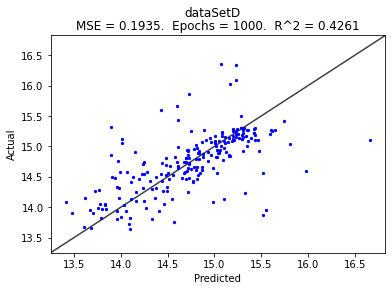

In [32]:
fig = plt.figure()
fig.patch.set_facecolor('white')
fig.patch.set_alpha(1)
ax = fig.add_subplot(111)

plt.suptitle(globalDasetName) # global name
plt.title(f'MSE = {model_mse:.4f}.  Epochs = {epochs}.  R^2 = {r_squared:.4f}') # MSE
plt.scatter(ypred_test, ytest, s=5, color="blue") # x_axis, y_axis, ...
plt.xlabel("Predicted")
plt.ylabel("Actual")

# plot y = x
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
# plt.aspect('equal')
plt.xlim(lims)
plt.ylim(lims)

In [81]:
# eval
difflst = []
for pred, actual in zip(ypred, ytest):
#     print(pred-actual)
    difflst.append(pred - actual)

difflst = np.array(difflst)

idx = np.arange(len(difflst))

UFuncTypeError: ufunc 'subtract' did not contain a loop with signature matching types (dtype('<U32'), dtype('<U32')) -> dtype('<U32')

NameError: name 'idx' is not defined

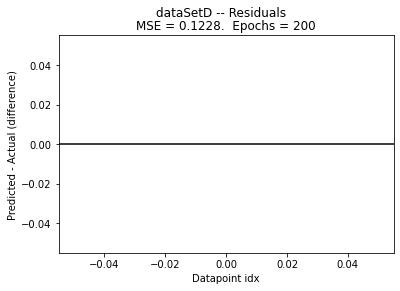

In [82]:
fig = plt.figure()

fig.patch.set_facecolor('white')
fig.patch.set_alpha(1)

ax = fig.add_subplot(111)



x_vals = np.arange(len(difflst))




plt.suptitle(F'{globalDasetName} -- Residuals') # global name
plt.title(f'MSE = {model_mse:.4f}.  Epochs = {epochs}') # MSE
plt.scatter(x_vals, difflst, s=5, color="red") # x_axis, y_axis, ...
plt.axhline(y=0, color='black', linestyle='-')
plt.xlabel("Datapoint idx")
plt.ylabel("Predicted - Actual (difference)")


# add labels for each datapoint
for i, txt in enumerate(idx):
    ax.annotate(txt, (x_vals[i], difflst[i]))

In [ ]:
# find r_2

correlation_matrix = np.corrcoef(ypred.flatten(), ytest)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2
r_squared

In [37]:
# find reliable outliers...

In [161]:
# too hard to then find indexes... 
# majorDiff = difflst[difflst < -0.5]
# difflst = majorDiff

outliersOverPointFive = {}

for idx, val in enumerate(difflst):
    val = val[0]
#     print(val)
    if val < -0.5:
        outliersOverPointFive[idx] = val

outliersOverPointFive

{14: -0.7060299,
 47: -0.5574045,
 49: -0.9893217,
 52: -1.3355742,
 70: -0.9470024,
 79: -1.0496731,
 91: -0.5910349,
 118: -0.59140396,
 123: -0.84061337,
 135: -1.6438999,
 141: -0.85076904,
 162: -0.83248043,
 166: -1.143404,
 174: -0.9715328,
 181: -0.51934814,
 189: -1.0088711,
 200: -0.91478443,
 205: -0.886055,
 206: -0.84465027}

In [177]:
# get diff, ypred and y_actual (ytest)

for idx in outliersOverPointFive.keys():
    outliersOverPointFive[idx] = [round(float(difflst[idx]), 4), round(float(ypred[idx]), 4), round(float(ytest[idx]), 4)]
print(f"Difference, predicted, actual")
outliersOverPointFive

Difference, predicted, actual


{14: [-0.706, 14.9721, 15.6781],
 47: [-0.5574, 15.1756, 15.733],
 49: [-0.9893, 15.0209, 16.0102],
 52: [-1.3356, 13.9842, 15.3198],
 70: [-0.947, 14.1316, 15.0786],
 79: [-1.0497, 13.9822, 15.0319],
 91: [-0.591, 14.1803, 14.7713],
 118: [-0.5914, 14.218, 14.8094],
 123: [-0.8406, 14.9282, 15.7688],
 135: [-1.6439, 14.4562, 16.1001],
 141: [-0.8508, 14.7885, 15.6392],
 162: [-0.8325, 14.2495, 15.082],
 166: [-1.1434, 14.4101, 15.5535],
 174: [-0.9715, 13.8538, 14.8253],
 181: [-0.5193, 14.3603, 14.8797],
 189: [-1.0089, 15.1337, 16.1426],
 200: [-0.9148, 14.7447, 15.6595],
 205: [-0.8861, 14.0191, 14.9051],
 206: [-0.8447, 14.2858, 15.1305]}

In [163]:
x_train, y_train = get_pandas_data()

In [168]:
here = 14
print(y_train[here])
print(x_train[here])

14.5221865908
[1.77006915 1.         0.         1.         0.         0.
 0.         1.         0.         0.         0.         0.
 1.         0.         0.         0.         0.         1.
 0.         1.         0.         1.         0.         0.
 1.         0.         1.         0.         1.         0.
 1.         1.         0.        ]


In [169]:
there = 13
print(y_train[there])
print(x_train[there])

14.3242551806
[2.00706683 1.         1.         0.         1.         0.
 0.         1.         1.         0.         1.         0.
 1.         0.         0.         1.         1.         0.
 0.         0.         1.         0.         1.         1.
 0.         1.         1.         0.         1.         0.
 1.         0.         1.        ]


In [150]:
conda list

# packages in environment at /lus/theta-fs0/software/thetagpu/conda/2021-11-30/mconda3:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                        main  
_openmp_mutex             4.5                       1_gnu  
absl-py                   1.0.0                    pypi_0    pypi
aiohttp                   3.8.1                    pypi_0    pypi
aiohttp-cors              0.7.0                    pypi_0    pypi
aioredis                  1.3.1                    pypi_0    pypi
aiosignal                 1.2.0                    pypi_0    pypi
altair                    4.1.0                    pypi_0    pypi
argon2-cffi               21.1.0                   pypi_0    pypi
asgiref                   3.4.1                    pypi_0    pypi
astor                     0.8.1                    pypi_0    pypi
astunparse                1.6.3                    pypi_0    pypi
async-timeout             4.0.1                    pypi_0    py

In [152]:
import tensorflow as tf
import datetime

In [153]:
%load_ext tensorboard
